In [1]:
import sys
sys.path.append('../')
import canopus
from monodromy.render import _plot_coverage_set
from qiskit import QuantumCircuit
import pytket.qasm
from qiskit.transpiler import PassManager
import qiskit
import numpy as np

In [2]:
cov = canopus.utils.get_stabilizer_isa_coverage()

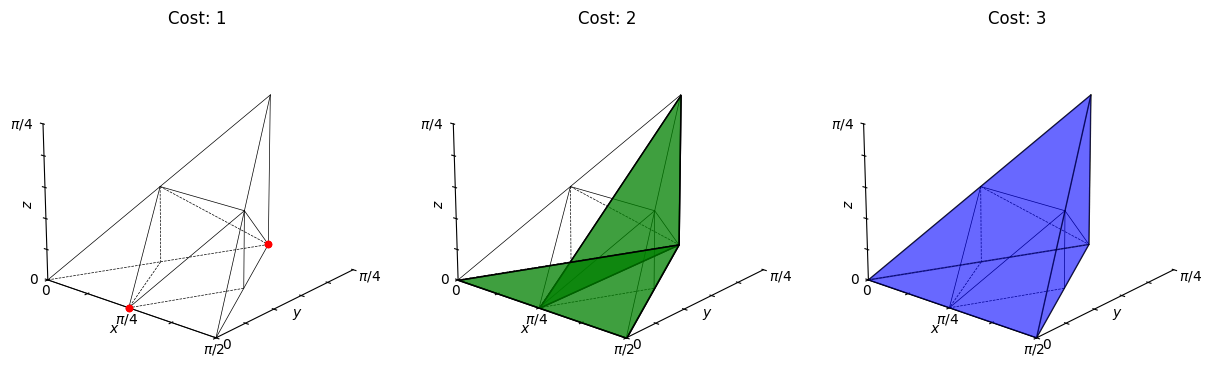

In [3]:
_plot_coverage_set(cov)

In [4]:
# qasm_fname = './qldpc_circ/gb_code/GBCode_[[18, 2, 5]]_Naive_CX.qasm'
qasm_fname = './qldpc_circ/steane_code/SteaneCode_[[7, 1, 3]]_Naive_CX.qasm'
qc = QuantumCircuit.from_qasm_file(qasm_fname)

# 此处考虑两种ISA: {CX, U3}; {CX, iSWAP, U3}
cx_cost_est = canopus.SynthCostEstimator('cx') # cx means {CX, U3} ISA
stab_isa_cost_est = canopus.SynthCostEstimator('stab') # stab means {CX, iSWAP, U3} ISA

In [5]:
print("cx   cost = ", cx_cost_est.eval_circuit_cost(qc))
print("stab cost = ", stab_isa_cost_est.eval_circuit_cost(qc))

cx   cost =  7.0
stab cost =  7.0


In [6]:
qc = canopus.rebase_to_tk2(qc)

In [7]:
def canopus_pass(qc, topology, isa):
    if topology == "chain":
        coupling_map = canopus.utils.gene_chain_coupling_map(qc.num_qubits)
    elif topology == "hhex":
        coupling_map = canopus.utils.gene_hhex_coupling_map(qc.num_qubits)
    elif topology == "square":
        coupling_map = canopus.utils.gene_square_coupling_map(qc.num_qubits)
    else:
        raise ValueError(f"Unsupported topology: {topology}")
    
    backend = canopus.CanopusBackend(coupling_map, isa)
    qc_mapped = PassManager(canopus.CanopusMapping(backend)).run(qc)
    return qc_mapped

def sabre_pass(qc, topology):
    if topology == "chain":
        coupling_map = canopus.utils.gene_chain_coupling_map(qc.num_qubits)
    elif topology == "hhex":
        coupling_map = canopus.utils.gene_hhex_coupling_map(qc.num_qubits)
    elif topology == "square":
        coupling_map = canopus.utils.gene_square_coupling_map(qc.num_qubits)
    else:
        raise ValueError(f"Unsupported topology: {topology}")
    
    backend = canopus.CanopusBackend(coupling_map)
    qc_mapped = PassManager(canopus.SabreMapping(backend)).run(qc)
    return qc_mapped

In [8]:
np.random.seed(123)

In [ ]:
qc_sabre = sabre_pass(qc, "square")
qc_sabre_rebase_tk2 = canopus.rebase_to_tk2(qc_sabre)

In [16]:
cx_cost_est.eval_circuit_cost(qc_sabre_rebase_tk2), stab_isa_cost_est.eval_circuit_cost(qc_sabre_rebase_tk2)

(23.0, 18.0)

In [17]:
# Routing by Canopus
qc_canopus_cx = canopus_pass(qc, "square", 'cx')
qc_canopus_stab = canopus_pass(qc, "square", 'stab')

In [18]:
initial_layout = qc_canopus_stab.layout.initial_layout
final_layout = qc_canopus_stab.layout.final_layout
print(initial_layout)

# print(initial_layout.get_virtual_bits())
for q,p in initial_layout.get_virtual_bits().items():
    global_index = qc_canopus_stab.qubits.index(q)
    print(f"Qubit {global_index} is mapped to physical qubit {p}")

Layout({
6: Qubit(QuantumRegister(13, 'q'), 0),
8: Qubit(QuantumRegister(13, 'q'), 1),
7: Qubit(QuantumRegister(13, 'q'), 2),
10: Qubit(QuantumRegister(13, 'q'), 3),
0: Qubit(QuantumRegister(13, 'q'), 4),
11: Qubit(QuantumRegister(13, 'q'), 5),
12: Qubit(QuantumRegister(13, 'q'), 6),
3: Qubit(QuantumRegister(13, 'q'), 7),
9: Qubit(QuantumRegister(13, 'q'), 8),
5: Qubit(QuantumRegister(13, 'q'), 9),
1: Qubit(QuantumRegister(13, 'q'), 10),
4: Qubit(QuantumRegister(13, 'q'), 11),
2: Qubit(QuantumRegister(13, 'q'), 12)
})
Qubit 0 is mapped to physical qubit 6
Qubit 1 is mapped to physical qubit 8
Qubit 2 is mapped to physical qubit 7
Qubit 3 is mapped to physical qubit 10
Qubit 4 is mapped to physical qubit 0
Qubit 5 is mapped to physical qubit 11
Qubit 6 is mapped to physical qubit 12
Qubit 7 is mapped to physical qubit 3
Qubit 8 is mapped to physical qubit 9
Qubit 9 is mapped to physical qubit 5
Qubit 10 is mapped to physical qubit 1
Qubit 11 is mapped to physical qubit 4
Qubit 12 is map

In [19]:
def get_layout(qc):
    ''' Returns the initial and final layout of the quantum circuit.'''
    initial_layout = qc.layout.initial_layout
    final_layout = qc.layout.final_layout
    log_to_phys_initial = {qc.qubits.index(q): p for q, p in initial_layout.get_virtual_bits().items()}
    log_to_phys_final = {qc.qubits.index(q): p for q, p in final_layout.get_virtual_bits().items()}
    return log_to_phys_initial, log_to_phys_final

# qc_canopus_stab.draw(fold=10000)
# print("Debug [Kai] 1-initial:", qc_canopus_stab.layout.initial_layout)
# print("Debug [Kai] 1-final  :", qc_canopus_stab.layout.final_layout)

log_to_phys_initial, log_to_phys_final = get_layout(qc_canopus_stab)
print("Debug [Kai] 2-initial:", log_to_phys_initial)
print("Debug [Kai] 2-final  :", log_to_phys_final)
# 以下是为了合并所有的 2Q 门到 Canonical 形式 
qc_canopus_cx_rebase_tk2 = canopus.rebase_to_tk2(qc_canopus_cx)
# print("Debug [Kai] 2:", qc_canopus_cx.layout.initial_layout)
qc_canopus_stab_rebase_tk2 = canopus.rebase_to_tk2(qc_canopus_stab)

Debug [Kai] 2-initial: {0: 6, 1: 8, 2: 7, 3: 10, 4: 0, 5: 11, 6: 12, 7: 3, 8: 9, 9: 5, 10: 1, 11: 4, 12: 2}
Debug [Kai] 2-final  : {0: 4, 1: 9, 2: 7, 3: 2, 4: 8, 5: 6, 6: 12, 7: 5, 8: 0, 9: 10, 10: 11, 11: 3, 12: 1}


In [20]:
qc_canopus_stab.draw(fold=10000)

┌────────────────┐                                                                                                                                        ┌───────────────┐                                                                                                                                                                                                                                                                       
 q_4 -> 0 ──┤ U(0,-π/2,3π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0              ├──────────────────────X──────────────────────────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X──────────────────────────────────────────────────────────────────────────────
            ├────────────────┤                                   ┌───────────────┐                                                                                    │  Can(0.5,0,0) │┌────────────┐        │                          │                                                          ┌───────────────┐┌───────────────┐                                          │                                           ┌───────────────┐  ┌────────────┐  
q_10 -> 1 ──┤ U(π,-π/2,7π/2) ├───────────────────────────────────┤0              ├─────────────────────────────────────────X─────────────────────────────────X────────┤1              ├┤ U(π/2,0,π) ├────────X──────────────────────────┼──────────────────────X───────────────────────────────────┤0              ├┤0              ├────────────────────────────────X─────────X────────────────X──────────────────────────┤0              ├──┤ U(π/2,0,π) ├──
           ┌┴────────────────┴┐                                  │               │                ┌───────────────┐        │                                 │        └───────────────┘└────────────┘                                   │                      │ ┌───────────────┐┌───────────────┐│  Can(0.5,0,0) ││               │┌───────────────┐               │                          │         ┌───────────────┐│  Can(0.5,0,0) │┌─┴────────────┴─┐
q_12 -> 2 ─┤ U(π/2,-π/2,3π/2) ├──────────────────────────────────┤               ├────────────────┤0              ├────────┼────────────────X────────────────X──────────────────────────────────────────────────────────────────────────┼──X───────────────────┼─┤0              ├┤ U(7π/2,π,π/2) ├┤1              ├┤               ├┤0              ├───────────────┼──────────────────────────X─────────┤0              ├┤1              ├┤ U(0,-π/2,3π/2) ├
          ┌┴──────────────────┤                 ┌───────────────┐│               │┌──────────────┐│               │        │                │                                                                         ┌───────────────┐ │  │ ┌───────────────┐ │ │  Can(0.5,0,0) │└───────────────┘└───────────────┘│               ││               │               │                                    │  Can(0.5,0,0) │├───────────────┤└─┬────────────┬─┘
 q_7 -> 3 ┤ U(3π/2,-π/2,3π/2) ├─────────────────┤0              ├┤               ├┤ U(π/2,0,π/2) ├┤               ├────────┼────────────────X─────────────────────────────────────────────────────────────────────────┤0              ├─┼──X─┤0              ├─┼─┤1              ├─────────────────────────X────────┤               ├┤               ├───────────────┼────────────────────────────────────┤1              ├┤0              ├──┤ U(π/2,0,π) ├──
          └─┬────────────────┬┘                 │               ││  Can(0.5,0,0) │└──────────────┘│               │        │                                                                                          │               │ │    │  Can(0.5,0,0) │ │ ├───────────────┤  ┌────────────┐         │        │  Can(0.5,0,0) ││               │               │                                    └───────────────┘│               │  └─────

In [23]:
cx_cost_est.eval_circuit_cost(qc_canopus_cx_rebase_tk2), stab_isa_cost_est.eval_circuit_cost(qc_canopus_stab_rebase_tk2)

(23.0, 18.0)

接下来将{Can,U3}转换为 Clifford2Q and Clifford1Q

In [24]:
qc_sabre_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_sabre_rebase_tk2)
qc_canopus_cx_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_canopus_cx_rebase_tk2)
qc_canopus_stab_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_canopus_stab_rebase_tk2, isa='stab')

In [25]:
cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qc_canopus_cx_rebase_tk2)), stab_isa_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qc_canopus_stab_rebase_tk2))

(23.0, 18.0)

In [28]:
print("Sabre:", qc_sabre_pre_stim.count_ops())
print("Canopus CX:", qc_canopus_cx_pre_stim.count_ops())
print("Canopus Stab:", qc_canopus_stab_pre_stim.count_ops())

Sabre: OrderedDict({'cx': 51, 'sx': 50, 'z': 36, 'sdg': 25, 's': 23})
Canopus CX: OrderedDict({'sx': 71, 'cx': 70, 'z': 34, 'sdg': 33, 's': 32})
Canopus Stab: OrderedDict({'sx': 77, 's': 59, 'sdg': 48, 'z': 32, 'cx': 31, 'iswap': 19})


In [29]:
from qiskit.qasm2 import dumps
print(type(qc_sabre_pre_stim))
qasm_str = dumps(qc_sabre_pre_stim)
print(qasm_str)

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
OPENQASM 2.0;
include "qelib1.inc";
qreg q[13];
z q[0];
sx q[0];
z q[0];
sx q[1];
sx q[1];
sx q[2];
z q[3];
sx q[4];
z q[4];
sx q[6];
sx q[7];
z q[7];
sdg q[8];
sx q[8];
z q[8];
sdg q[9];
sx q[9];
sdg q[9];
cx q[9],q[4];
z q[4];
cx q[4],q[3];
cx q[3],q[4];
cx q[4],q[3];
s q[3];
sx q[3];
cx q[3],q[2];
z q[2];
z q[3];
sx q[3];
sdg q[3];
sx q[4];
z q[4];
cx q[8],q[3];
sdg q[3];
sx q[3];
sdg q[8];
s q[9];
sx q[9];
sdg q[9];
cx q[9],q[4];
z q[4];
s q[10];
sx q[10];
cx q[10],q[5];
cx q[5],q[0];
z q[0];
sx q[0];
z q[0];
s q[10];
sx q[10];
s q[10];
cx q[10],q[5];
cx q[5],q[10];
cx q[10],q[5];
z q[11];
sx q[11];
z q[11];
sdg q[12];
sx q[12];
sdg q[12];
cx q[12],q[7];
sdg q[7];
sx q[7];
cx q[7],q[6];
z q[6];
cx q[6],q[5];
cx q[5],q[6];
cx q[6],q[5];
sx q[5];
z q[5];
s q[6];
sx q[6];
cx q[6],q[1];
z q[1];
cx q[2],q[1];
cx q[1],q[2];
cx q[2],q[1];
sx q[1];
z q[1];
sx q[2];
z q[2];
sdg q[6];
cx q[6],q[5];
sx q[5];
sdg q[5];
sdg q[6];
cx q[6],q[

In [30]:
qc_sabre_pre_stim.draw(fold=10000)

global phase: 3π/2
       ┌───┐ ┌────┐ ┌───┐           ┌───┐ ┌───┐ ┌────┐ ┌───┐                                                                                                                                                                                         ┌───┐  ┌───┐ ┌────┐ ┌───┐        ┌───┐┌───┐┌────┐ ┌───┐                          ┌───┐                    
 q_0: ─┤ Z ├─┤ √X ├─┤ Z ├───────────┤ X ├─┤ Z ├─┤ √X ├─┤ Z ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├──┤ Z ├─┤ √X ├─┤ Z ├────────┤ X ├┤ Z ├┤ √X ├─┤ Z ├──────────────────────────┤ X ├────────────────────
       ├───┴┐├────┤ └───┘           └─┬─┘ └───┘ └────┘ └───┘                                                                 ┌───┐  ┌───┐ ┌───┐         ┌───┐ ┌────┐┌───┐┌───┐┌─────┐┌────┐┌───┐                         ┌───┐      ┌───┐┌───┐ ┌────┐└─┬─┘  ├───┤ ├────┤┌┴───┴┐       └─┬─┘├───┤├───┬┘ ├───┤        ┌───┐ ┌───┐ ┌────┐└─┬─┘                    
 q_1: ─┤ √X ├┤ √X ├───────────────────┼──────────────────────────────────────────────────────────────────────────────────────┤ X ├──┤ Z ├─┤ X ├────■────┤ X ├─┤ √X ├┤ Z ├┤ X ├┤ Sdg ├┤ √X ├┤ S ├─────────────────────────┤ X ├──■───┤ X ├┤ S ├─┤ √X ├──■────┤ Z ├─┤ √X ├┤ Sdg ├─────────┼──┤ X ├┤ Z ├──┤ X ├───■────┤ X ├─┤ S ├─┤ √X ├──■──────────────────────
       ├────┤└────┘                   │                                        ┌───┐┌───┐                                    └─┬─┘  └───┘ └─┬─┘  ┌─┴─┐  └─┬─┘ ├────┤├───┤└─┬─┘└┬───┬┘├───┬┘├───┴┐ ┌───┐ ┌───┐┌────┐┌───┐ └─┬─┘┌─┴─┐ └─┬─┘├───┴┐├───┬┘       ├───┤ ├───┬┘└─────┘         │  └─┬─┘└───┘  └─┬─┘ ┌─┴─┐  └─┬─┘ ├───┴┐├───┬┘┌───┐┌─────┐┌────┐ ┌───┐ 
 q_2: ─┤ √X ├─────────────────────────┼────────────────────────────────────────┤ X ├┤ Z ├──────────────────────────────────────┼────────────■────┤ X ├────■───┤ √X ├┤ Z ├──┼───┤ X ├─┤ Z ├─┤ √X ├─┤ Z ├─┤ X ├┤ √X ├┤ S ├───■──┤ X ├───■──┤ √X ├┤ Z ├────────┤ X ├─┤ Z ├─────────────────┼────┼───────────■───┤ X ├────■───┤ √X ├┤ Z ├─┤ X ├┤ Sdg ├┤ √X ├─┤ S ├─
       ├───┬┘                         │         ┌───┐        ┌───┐┌───┐  ┌────┐└─┬─┘├───┤┌────┐┌─────┐                 ┌───┐   │   ┌─────┐┌────┐ └───┘        └────┘└───┘  │   └─┬─┘ └───┘ └────┘ └───┘ └─┬─┘├───┬┘├───┴┐┌───┐├───┤      ├───┬┘├───┤ ┌────┐ └─┬─┘ ├───┤  ┌────┐┌─────┐  │    │  ┌───┐ ┌─────┐├───┴┐       └────┘└───┘ └─┬─┘└┬───┬┘├────┤┌┴───┴┐
 q_3: ─┤ Z ├──────────────────────────┼─────────┤ X ├────■───┤ X ├┤ S ├──┤ √X ├──■──┤ Z ├┤ √X ├┤ Sdg ├─────────────────┤ X ├───┼───┤ Sdg ├┤ √X ├───────────────────────────┼─────┼────────────────────────■──┤ S ├─┤ √X ├┤ S ├┤ X ├───■──┤ X ├─┤ S ├─┤ √X ├───■───┤ Z ├──┤ √X ├┤ Sdg ├──┼────┼──┤ X ├─┤ Sdg ├┤ √X ├─────────────────────■───┤ S ├─┤ √X ├┤ Sdg ├
       ├───┴┐┌───┐             ┌───┐  │   ┌───┐ └─┬─┘  ┌─┴─┐ └─┬─┘├───┴┐ ├───┬┘     └───┘├───┬┘└┬───┬┘                 └─┬─┘   │   └─────┘└────┘                           │     │                           └───┘ └────┘└───┘└─┬─┘ ┌─┴─┐└─┬─┘ └───┘ └────┘       └───┘  └────┘└─────┘  │    │  └─┬─┘ └─────┘└────┘                         └───┘ └────┘└─────┘
 q_4: ─┤ √X ├┤ Z ├─────────────┤ X ├──┼───┤ Z ├───■────┤ X ├───■──┤ √X ├─┤ Z ├───────────┤ X ├──┤ Z ├────────────────────┼─────┼───────────────────────────────────────────┼─────┼──────────────────────────────────────────────■───┤ X ├──■────────────────────────────────────────────┼────┼────┼────────────────────────────────────────────────────────────
       └────┘└───┘        ┌───┐└─┬─┘  │   └───┘        └───┘ ┌───┐└────┘ └───┘ ┌───┐┌───┐└─┬─┘  └───┘ ┌───┐┌────┐┌───┐   │     │          ┌───┐  ┌────┐┌─────┐             │     │                                                  └───┘            ┌───┐ ┌─────┐┌────┐                │    │    │                                                            
 q_5: ────────────────────┤ X ├──┼────■──────────────────────┤ X ├──■──────────┤ X ├┤ X ├──┼──────■───┤ X ├┤ 

In [31]:
from qiskit import transpile
# qc_sabre_rebase_tk2.layers()
qc_canopus_stab_pre_stim.depth()
# scheduled_circ = transpile(qc_sabre_pre_stim, scheduling_method='asap')  # or 'asap'
# print(scheduled_circ.qasm()) 

61

In [32]:
qasm_str_canopus = dumps(qc_canopus_stab_pre_stim)
print(qasm_str_canopus)

OPENQASM 2.0;
include "qelib1.inc";
gate iswap q0,q1 { s q0; s q1; h q0; cx q0,q1; cx q1,q0; h q1; }
qreg q[13];
sdg q[0];
sx q[0];
z q[0];
sdg q[1];
sx q[1];
sx q[2];
sx q[2];
sdg q[4];
sx q[4];
z q[4];
s q[6];
sx q[6];
cx q[6],q[5];
z q[5];
sx q[6];
sx q[6];
s q[6];
iswap q[6],q[1];
z q[1];
sx q[1];
sdg q[1];
sdg q[6];
sx q[6];
sdg q[6];
sx q[7];
z q[7];
s q[8];
sx q[8];
cx q[8],q[3];
z q[3];
sx q[3];
s q[3];
s q[8];
s q[9];
sx q[9];
iswap q[9],q[8];
z q[8];
sx q[8];
sx q[8];
z q[9];
sx q[9];
s q[9];
s q[10];
sx q[10];
z q[10];
iswap q[10],q[5];
s q[5];
sx q[5];
s q[5];
s q[10];
z q[11];
sx q[11];
z q[11];
sdg q[12];
sx q[12];
sdg q[12];
cx q[12],q[7];
sdg q[7];
sx q[7];
cx q[7],q[2];
z q[2];
cx q[3],q[2];
s q[2];
sx q[2];
sdg q[3];
iswap q[3],q[2];
cx q[2],q[1];
s q[1];
sx q[1];
sdg q[2];
iswap q[2],q[1];
sdg q[1];
sx q[1];
z q[1];
iswap q[1],q[0];
sx q[0];
sx q[0];
sdg q[0];
z q[1];
sx q[1];
s q[1];
s q[2];
sx q[2];
s q[2];
z q[3];
sx q[3];
sdg q[3];
z q[7];
sx q[7];
sdg q[7];
cx q

In [33]:
qc_sabre_pre_stim.draw(fold=10000)

global phase: 3π/2
       ┌───┐ ┌────┐ ┌───┐           ┌───┐ ┌───┐ ┌────┐ ┌───┐                                                                                                                                                                                         ┌───┐  ┌───┐ ┌────┐ ┌───┐        ┌───┐┌───┐┌────┐ ┌───┐                          ┌───┐                    
 q_0: ─┤ Z ├─┤ √X ├─┤ Z ├───────────┤ X ├─┤ Z ├─┤ √X ├─┤ Z ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├──┤ Z ├─┤ √X ├─┤ Z ├────────┤ X ├┤ Z ├┤ √X ├─┤ Z ├──────────────────────────┤ X ├────────────────────
       ├───┴┐├────┤ └───┘           └─┬─┘ └───┘ └────┘ └───┘                                                                 ┌───┐  ┌───┐ ┌───┐         ┌───┐ ┌────┐┌───┐┌───┐┌─────┐┌────┐┌───┐                         ┌───┐      ┌───┐┌───┐ ┌────┐└─┬─┘  ├───┤ ├────┤┌┴───┴┐       └─┬─┘├───┤├───┬┘ ├───┤        ┌───┐ ┌───┐ ┌────┐└─┬─┘                    
 q_1: ─┤ √X ├┤ √X ├───────────────────┼──────────────────────────────────────────────────────────────────────────────────────┤ X ├──┤ Z ├─┤ X ├────■────┤ X ├─┤ √X ├┤ Z ├┤ X ├┤ Sdg ├┤ √X ├┤ S ├─────────────────────────┤ X ├──■───┤ X ├┤ S ├─┤ √X ├──■────┤ Z ├─┤ √X ├┤ Sdg ├─────────┼──┤ X ├┤ Z ├──┤ X ├───■────┤ X ├─┤ S ├─┤ √X ├──■──────────────────────
       ├────┤└────┘                   │                                        ┌───┐┌───┐                                    └─┬─┘  └───┘ └─┬─┘  ┌─┴─┐  └─┬─┘ ├────┤├───┤└─┬─┘└┬───┬┘├───┬┘├───┴┐ ┌───┐ ┌───┐┌────┐┌───┐ └─┬─┘┌─┴─┐ └─┬─┘├───┴┐├───┬┘       ├───┤ ├───┬┘└─────┘         │  └─┬─┘└───┘  └─┬─┘ ┌─┴─┐  └─┬─┘ ├───┴┐├───┬┘┌───┐┌─────┐┌────┐ ┌───┐ 
 q_2: ─┤ √X ├─────────────────────────┼────────────────────────────────────────┤ X ├┤ Z ├──────────────────────────────────────┼────────────■────┤ X ├────■───┤ √X ├┤ Z ├──┼───┤ X ├─┤ Z ├─┤ √X ├─┤ Z ├─┤ X ├┤ √X ├┤ S ├───■──┤ X ├───■──┤ √X ├┤ Z ├────────┤ X ├─┤ Z ├─────────────────┼────┼───────────■───┤ X ├────■───┤ √X ├┤ Z ├─┤ X ├┤ Sdg ├┤ √X ├─┤ S ├─
       ├───┬┘                         │         ┌───┐        ┌───┐┌───┐  ┌────┐└─┬─┘├───┤┌────┐┌─────┐                 ┌───┐   │   ┌─────┐┌────┐ └───┘        └────┘└───┘  │   └─┬─┘ └───┘ └────┘ └───┘ └─┬─┘├───┬┘├───┴┐┌───┐├───┤      ├───┬┘├───┤ ┌────┐ └─┬─┘ ├───┤  ┌────┐┌─────┐  │    │  ┌───┐ ┌─────┐├───┴┐       └────┘└───┘ └─┬─┘└┬───┬┘├────┤┌┴───┴┐
 q_3: ─┤ Z ├──────────────────────────┼─────────┤ X ├────■───┤ X ├┤ S ├──┤ √X ├──■──┤ Z ├┤ √X ├┤ Sdg ├─────────────────┤ X ├───┼───┤ Sdg ├┤ √X ├───────────────────────────┼─────┼────────────────────────■──┤ S ├─┤ √X ├┤ S ├┤ X ├───■──┤ X ├─┤ S ├─┤ √X ├───■───┤ Z ├──┤ √X ├┤ Sdg ├──┼────┼──┤ X ├─┤ Sdg ├┤ √X ├─────────────────────■───┤ S ├─┤ √X ├┤ Sdg ├
       ├───┴┐┌───┐             ┌───┐  │   ┌───┐ └─┬─┘  ┌─┴─┐ └─┬─┘├───┴┐ ├───┬┘     └───┘├───┬┘└┬───┬┘                 └─┬─┘   │   └─────┘└────┘                           │     │                           └───┘ └────┘└───┘└─┬─┘ ┌─┴─┐└─┬─┘ └───┘ └────┘       └───┘  └────┘└─────┘  │    │  └─┬─┘ └─────┘└────┘                         └───┘ └────┘└─────┘
 q_4: ─┤ √X ├┤ Z ├─────────────┤ X ├──┼───┤ Z ├───■────┤ X ├───■──┤ √X ├─┤ Z ├───────────┤ X ├──┤ Z ├────────────────────┼─────┼───────────────────────────────────────────┼─────┼──────────────────────────────────────────────■───┤ X ├──■────────────────────────────────────────────┼────┼────┼────────────────────────────────────────────────────────────
       └────┘└───┘        ┌───┐└─┬─┘  │   └───┘        └───┘ ┌───┐└────┘ └───┘ ┌───┐┌───┐└─┬─┘  └───┘ ┌───┐┌────┐┌───┐   │     │          ┌───┐  ┌────┐┌─────┐             │     │                                                  └───┘            ┌───┐ ┌─────┐┌────┐                │    │    │                                                            
 q_5: ────────────────────┤ X ├──┼────■──────────────────────┤ X ├──■──────────┤ X ├┤ X ├──┼──────■───┤ X ├┤ 

In [34]:
import stim

stim_circ = stim.Circuit()

qc_pre_stim = qc_canopus_stab_pre_stim # 选择要转换的量子线路
num_qubits = qc_pre_stim.num_qubits    # 量子线路 qc_pre_stim 里面的量子比特数量
num_clbits = qc_pre_stim.num_clbits    # 量子线路 qc_pre_stim 里面的经典比特数量
# print(num_qubits, num_clbits)

stim_circ.append("R", [i for i in range(num_qubits)])
for instruction in qc_pre_stim.data:
    gate = instruction.operation
    qubit_indices = [qc_pre_stim.qubits.index(q) for q in instruction.qubits]
    # classical bits if needed: instruction.clbits

    name = gate.name.lower()

    if name == 'h':
        stim_circ.append("H", [qubit_indices[0]])
    elif name in ('cx', 'cnot'):
        stim_circ.append("CNOT", [qubit_indices[0], qubit_indices[1]])
    elif name == 'cz':
        stim_circ.append("CZ", [qubit_indices[0], qubit_indices[1]])
    elif name == 's':
        stim_circ.append("S", [qubit_indices[0]])
    elif name in ('sdg', 's_dag', 'sdag'):
        stim_circ.append("S_DAG", [qubit_indices[0]])
    elif name == 'x':
        stim_circ.append("X", [qubit_indices[0]])
    elif name in ('sx', 'sqrtx'):
        stim_circ.append("SQRT_X", [qubit_indices[0]])
    elif name == 'y':
        stim_circ.append("Y", [qubit_indices[0]])
    elif name in ('sy', 'sqrty'):
        stim_circ.append("SQRT_Y", [qubit_indices[0]])
    elif name == 'z':
        stim_circ.append("Z", [qubit_indices[0]])
    elif name in ('sz', 'sqrtz'):
        stim_circ.append("SQRT_Z", [qubit_indices[0]])
    elif name == 'swap':
        stim_circ.append("SWAP", [qubit_indices[0], qubit_indices[1]])
    elif name == 'iswap':
        stim_circ.append("ISWAP", [qubit_indices[0], qubit_indices[1]])
    elif name == 'measure':
        stim_circ.append("M", [qubit_indices[0]])
    else:
        raise ValueError(f"Unsupported gate: {gate.name}")
    
# random measurement test
stim_circ.append("M", [i for i in range(10)])
print(stim_circ)

R 0 1 2 3 4 5 6 7 8 9 10 11 12
S_DAG 0
SQRT_X 0
Z 0
S_DAG 1
SQRT_X 1 2 2
S_DAG 4
SQRT_X 4
Z 4
S 6
SQRT_X 6
CX 6 5
Z 5
SQRT_X 6 6
S 6
ISWAP 6 1
Z 1
SQRT_X 1
S_DAG 1 6
SQRT_X 6
S_DAG 6
SQRT_X 7
Z 7
S 8
SQRT_X 8
CX 8 3
Z 3
SQRT_X 3
S 3 8 9
SQRT_X 9
ISWAP 9 8
Z 8
SQRT_X 8 8
Z 9
SQRT_X 9
S 9 10
SQRT_X 10
Z 10
ISWAP 10 5
S 5
SQRT_X 5
S 5 10
Z 11
SQRT_X 11
Z 11
S_DAG 12
SQRT_X 12
S_DAG 12
CX 12 7
S_DAG 7
SQRT_X 7
CX 7 2
Z 2
CX 3 2
S 2
SQRT_X 2
S_DAG 3
ISWAP 3 2
CX 2 1
S 1
SQRT_X 1
S_DAG 2
ISWAP 2 1
S_DAG 1
SQRT_X 1
Z 1
ISWAP 1 0
SQRT_X 0 0
S_DAG 0
Z 1
SQRT_X 1
S 1 2
SQRT_X 2
S 2
Z 3
SQRT_X 3
S_DAG 3
Z 7
SQRT_X 7
S_DAG 7
CX 8 7
S_DAG 7
SQRT_X 7
CX 7 6
S 6
CX 6 5
Z 5
CX 5 0
S 0
SQRT_X 0
S_DAG 5
ISWAP 5 0
S 5
SQRT_X 5
S 5 6
SQRT_X 6
S 6 7
SQRT_X 7
S 7
CX 9 8
S 8
SQRT_X 8
S_DAG 9
ISWAP 9 8
S 8
SQRT_X 8
CX 8 3
Z 3
CX 3 2
S 2
SQRT_X 2
S_DAG 3
ISWAP 3 2
SQRT_X 2
Z 2 3
SQRT_X 3
S_DAG 3
CX 4 3
S_DAG 3
SQRT_X 3
CX 3 2
Z 2
S 3
SQRT_X 3
S 3
Z 4
SQRT_X 4
S_DAG 4
S 8
SQRT_X 8
S 8 9
SQRT_X 9
S 9
CX 9 8
S 8


In [35]:
sampler = stim_circ.compile_sampler()
syndrome_matrix = sampler.sample(shots=100)  # shape: (100, num_measurements)
print(syndrome_matrix)
# syndrome_matrix, actual_observables = sampler.sample(shots=100, separate_observables=True)
# print(syndrome_matrix, actual_observables)
print(stim_circ)

[[False  True False False False  True False  True False False]
 [ True False False  True False False False False False False]
 [False False False False  True False False  True False False]
 [False False False False False False False  True False  True]
 [False False False False  True False False  True False False]
 [False  True False  True  True False False False False False]
 [ True  True False  True  True  True False  True False  True]
 [ True  True False  True  True  True False  True False False]
 [ True False False  True False False False False False  True]
 [ True  True False False False False False False False False]
 [ True  True False  True False  True False False False  True]
 [False  True False False False  True False  True False  True]
 [ True  True False  True False  True False False False False]
 [False False False  True  True  True False  True False  True]
 [False  True False False  True  True False False False False]
 [ True False False False False  True False  True False